Note: This notebook needs to be run with a GPU

In [1]:
import sys
from pathlib import Path
import os 
sys.path.append('/home/gridsan/vyuan/.local/lib/python3.9/site-packages/')

current_path = Path.cwd()

# Go to top of the root and append
root = current_path.parents[3]
sys.path.append(str(root))

os.chdir(root)

In [3]:
import torch
import os
import random
import json
from pathlib import Path

from fairness_cv_project.methods.label_free_cbm.src.plots import plots
from fairness_cv_project.methods.label_free_cbm.src.utils import data_utils, utils
from fairness_cv_project.methods.label_free_cbm.src.models import cbm

In [21]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/imSitu/30_verbs/CBM/sparse/balanced/imSitu_30_balanced_imSitu_30_filtered"
path_model_dir = root / load_dir
device = "cuda" if torch.cuda.is_available() else 'cpu'


with open(root / os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
    
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device, root)
model = cbm.load_cbm(path_model_dir, device)

In [22]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [23]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [7]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 3/3 [00:17<00:00,  5.92s/it]

Accuracy: 39.65%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [20]:
model.final.weight[10]

176

In [28]:
to_show = random.choices([i for i in range(len(classes))], k=2)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:12 - talking
Incoming weights:
a desk [0.1778] talking
a dustpan [0.0956] talking
a hunched over posture [0.4566] talking
a keyboard [0.2480] talking
a kitchen [0.0800] talking
a massage table [0.0753] talking
a sweat scraper [0.0510] talking
a wheelchair [0.1036] talking
Output class:10 - resting
Incoming weights:
a highway [0.6710] resting
a person [0.0924] resting
a sign with the destination [0.4116] resting
a street [0.0567] resting
moving [0.2320] resting
positive feelings [0.0634] resting
thumb out [0.0898] resting
traveling [0.3375] resting


In [9]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 11 - vacuuming
Highest weights: their arms around each other:0.661, tenderness:0.239, their heads close together:0.236, a rounded shoulders:0.234, a comforter:0.224, 
Lowest weights: the ability to produce speech:-0.222, a person sitting up:-0.207, metabolizing:-0.201, can be done with straw:-0.192, a keyboard:-0.162, 

Class 18 - rehabilitating
Highest weights: position:0.388, a instrument:0.339, music:0.293, movement:0.285, a music stand:0.239, 
Lowest weights: a fridge:-0.216, their arms around each other:-0.187, a tongue:-0.180, a hospital:-0.173, nonverbal communication:-0.155, 



In [10]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:176/176


## Explain model reasoning for random inputs

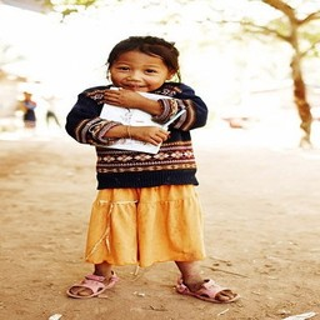

Image:448 Gt:vacuuming, 1st Pred:hugging, 4.352, 2nd Pred:reading, 3.494


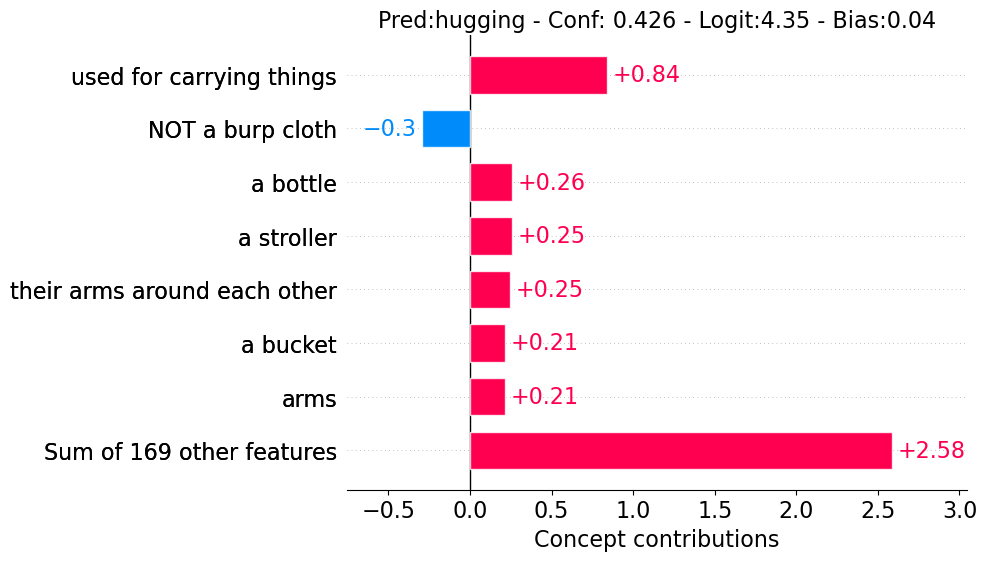

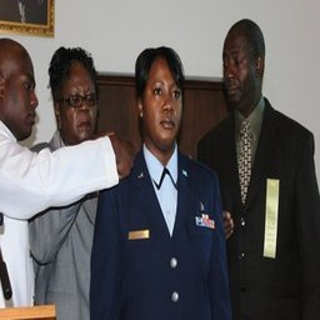

Image:666 Gt:smelling, 1st Pred:smelling, 3.830, 2nd Pred:sitting, 2.812


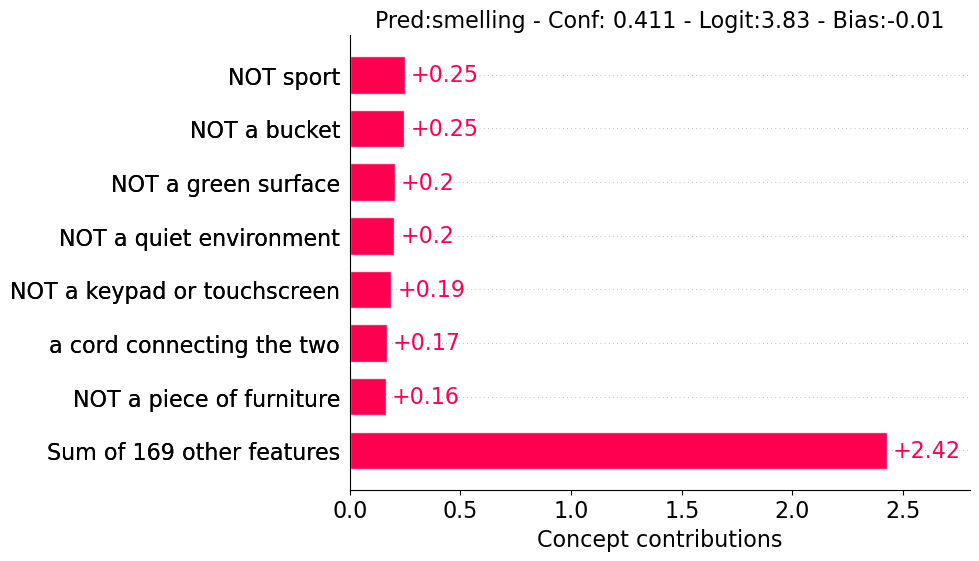

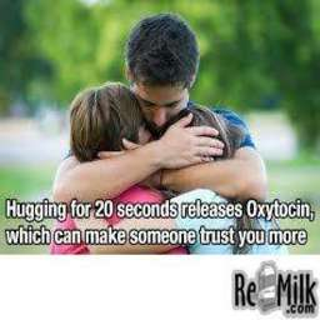

Image:439 Gt:vacuuming, 1st Pred:vacuuming, 3.491, 2nd Pred:reading, 3.199


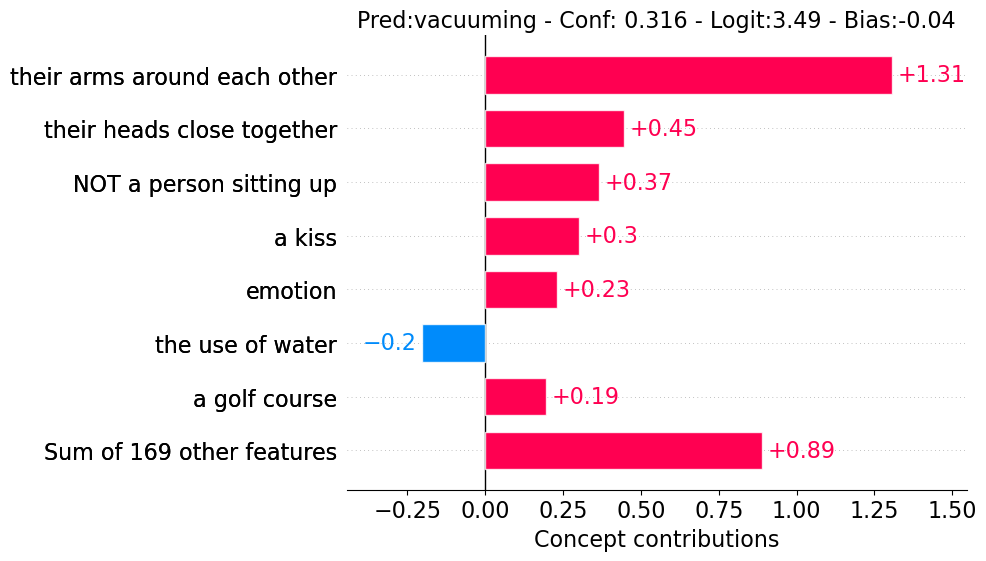

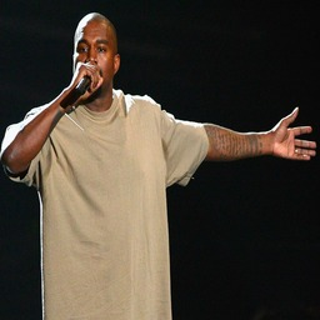

Image:1078 Gt:rubbing, 1st Pred:rehabilitating, 2.784, 2nd Pred:putting, 2.330


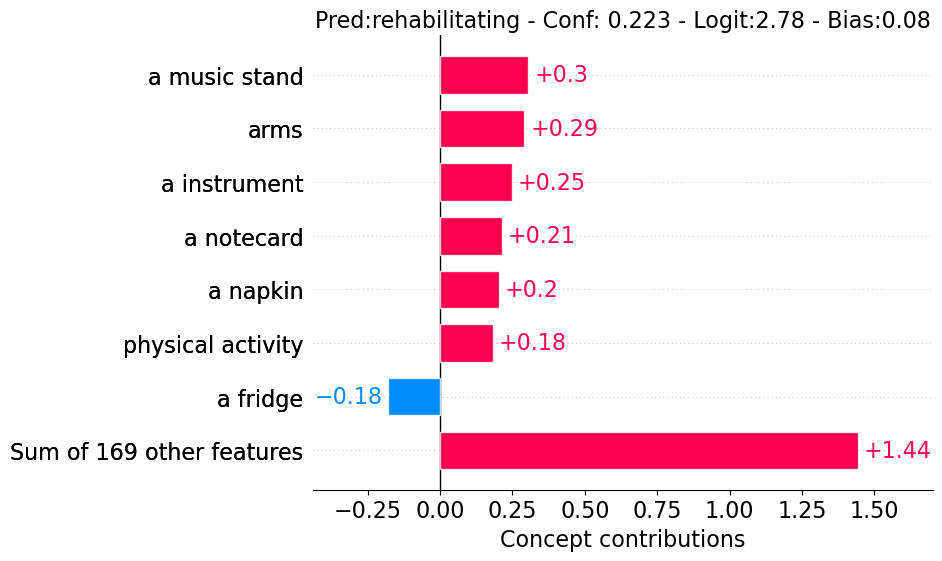

In [11]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)